# CWCL - Chasing Winner Cutting Loser

## 1. load data

In [70]:
library(xts)
library(ggplot2)
library(scales)
library(plyr)
library(TTR)

library(repr)
options(repr.plot.width = 12)
options(repr.plot.height = 6)

In [25]:
load("stockdata.RData")
length(stockData)

[1] 455

In [33]:
print(class(stockData$AAPL))
first(stockData$AAPL, "5 days")

[1] "xts" "zoo"


           AAPL.Open AAPL.High AAPL.Low AAPL.Close AAPL.Volume AAPL.Adjusted
2005-01-13     73.71     74.42    69.73      69.80   791179200      4.521628
2005-01-14     70.25     71.72    69.19      70.20   442685600      4.547540
2005-01-18     69.85     70.70    67.75      70.65   251615000      4.576691
2005-01-19     70.49     71.46    69.75      69.88   187973800      4.526811
2005-01-20     69.65     71.27    69.47      70.46   228730600      4.564383

## 2. cwcl model

cwcl model calculate the most recent m days' highest price and the most n days' lowest price. The model will consider the buy signal as  the current close price greater or equal to the most recent m day's highest price. The sell signal of this model is when the close price lower or equal to the most recent n days' lowest price.

In [48]:
# Plot close price, high price and low price
drawLine <- function(data, title="Stock", sDate=min(index(data)), 
                     eDate=max(index(data)), breaks="1 year"){
    if(sDate < min(index(data))) sDate = min(index(data))
    if(eDate > max(index(data))) eDate = max(index(data))
    data <- na.omit(data)    # Remove na values
    
    g <- ggplot(aes(x=Index, y=Value), data=fortify(data[, 1], melt=T))
    g <- g + geom_line()
        
    if(ncol(data) > 1){
        g <- g + geom_line(aes(colour=Series), data=fortify(data[, -1], melt=T))
    }
    
    g <- g + scale_x_date(labels=date_format("%Y-%m"), breaks=date_breaks(breaks),
                          limits=c(sDate, eDate))
    g <- g + ylim(min(data), max(data))
    g <- g + xlab("") + ylab("Price") + ggtitle(title)
    g
}

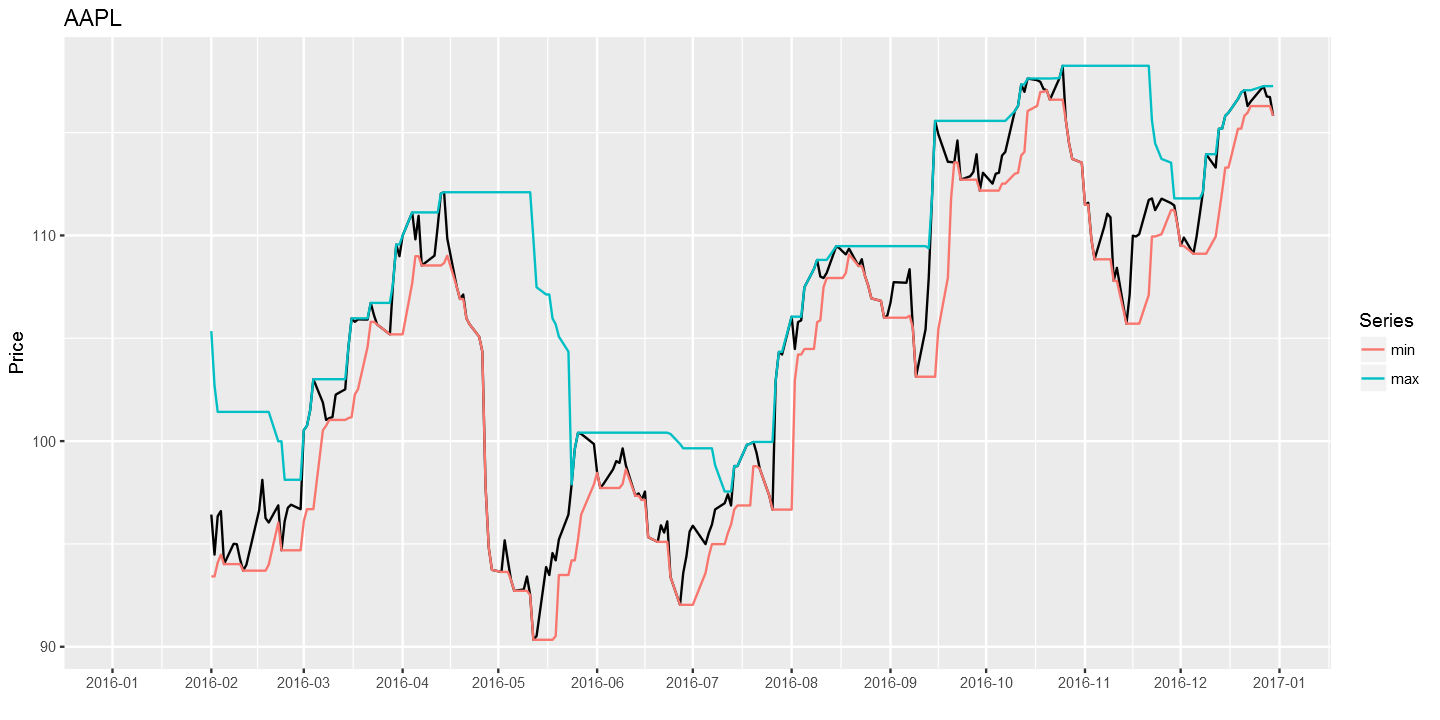

In [122]:
title <- 'AAPL'
stock <- data[[title]]
sDate <- as.Date("2016-01-01")
eDate <- as.Date("2017-01-01")
cdata <- stock["2016-01-01/2017-01-01", 4]
vdata <- stock["2016-01-01/2017-01-01", 5]

# calculate the recent 20 days highest price and 10 days lowest price
minmax <- function(data, max=20, min=10){
    d1 <- na.locf(data, fromLast=T)
    d2 <- merge(d1, min=runMin(d1, min), max=runMax(d1, max))
    return(d2[, -1])
}

ldata <- cbind(cdata, minmax(cdata， max=20, min=5))
# drawLine(cdata, title, sDate, eDate, '1 month')
drawLine(ldata, title, sDate, eDate, '1 month')

### Define buy point and sell point

In [123]:
buyPoint <- function(ldata){
    idx <- which(ldata[, 1] == ldata$max)
    return(ldata[idx, ])
}

buydata <- buyPoint(ldata)
buydata

           AAPL.Close    min    max
2016-03-01     100.53  96.10 100.53
2016-03-02     100.75  96.69 100.75
2016-03-03     101.50  96.69 101.50
2016-03-04     103.01  96.69 103.01
2016-03-15     104.58 101.12 104.58
2016-03-16     105.97 101.17 105.97
2016-03-22     106.72 105.80 106.72
2016-03-29     107.68 105.19 107.68
2016-03-30     109.56 105.19 109.56
2016-04-01     109.99 105.19 109.99
2016-04-04     111.12 107.68 111.12
2016-04-13     112.04 108.54 112.04
2016-04-14     112.10 108.66 112.10
2016-05-24      97.90  94.20  97.90
2016-05-25      99.62  94.20  99.62
2016-05-26     100.41  95.22 100.41
2016-07-14      98.79  96.68  98.79
2016-07-18      99.83  96.87  99.83
2016-07-19      99.87  96.87  99.87
2016-07-20      99.96  98.78  99.96
2016-07-27     102.95  96.67 102.95
2016-07-28     104.34  96.67 104.34
2016-08-01     106.05  96.67 106.05
2016-08-05     107.48 104.48 107.48
2016-08-08     108.37 104.48 108.37
2016-08-09     108.81 105.79 108.81
2016-08-15     109.48 107.93

Warning message in structure(as.numeric(x), names = names(x)):
"NAs introduced by coercion"

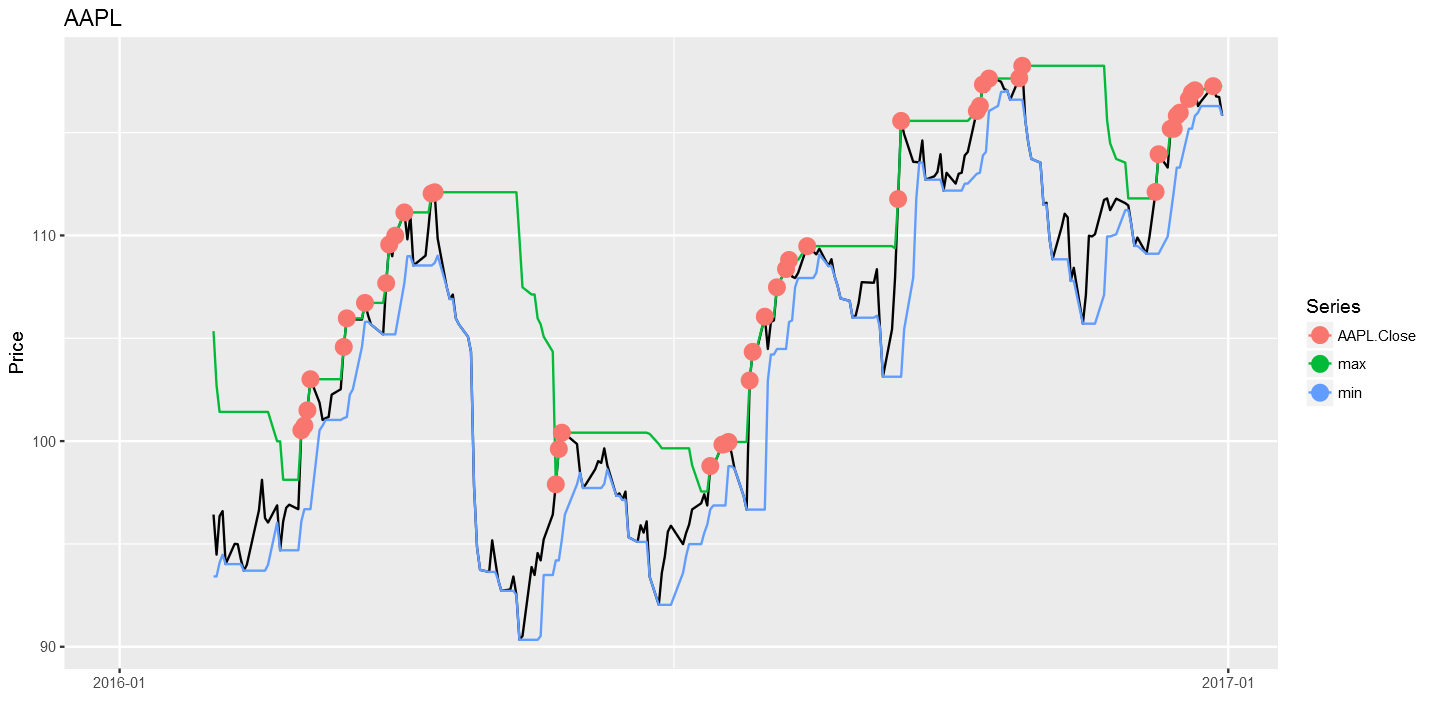

In [124]:
# Draw the buy signal
drawPoint <- function(ldata, pdata, title, sDate, eDate, breaks="1 year"){
    ldata <- na.omit(ldata)
    g <- ggplot(aes(x=Index, y=Value), data=fortify(ldata[, 1], melt=T))
    g <- g + geom_line()
    g <- g + geom_line(aes(colour=Series), data=fortify(ldata[, -1], melt=T))
    
    if(is.data.frame(pdata)){
        g <- g + geom_point(aes(x=Index, y=Value, colour=op), data=pdata, size=4)
    }else{
        g <- g + geom_point(aes(x=Index, y=Value, colour=Series), 
                            data=na.omit(fortify(pdata, melt=T)), 
                            size=4)
    }
    g <- g + scale_x_date(labels=date_format("%Y-%m"), breaks=date_breaks(breaks), 
                          limits=c(sDate, eDate))
    g <- g + xlab("") + ylab("Price") + ggtitle(title)
    g
}

drawPoint(ldata, buydata[, 1], title, sDate, '1 month')

In [125]:
stopPoint <- function(ldata, buydata){
    idx <- which(ldata[, 1] == ldata$min)
    idx <- idx[which(c(0, diff(idx)) != 1)]
    selldata <- ldata[idx, ]                  # All points smaller than minimum
    idx2 <- sapply(index(buydata), function(e){
        head(which(index(selldata) > e), 1)
    })
    
    return(selldata[unique(idx2), ])
}

selldata <- stopPoint(ldata, buydata)
selldata

           AAPL.Close    min    max
2016-03-24     105.67 105.67 106.72
2016-04-07     108.54 108.54 111.12
2016-04-18     107.48 107.48 112.10
2016-06-01      98.46  98.46 100.41
2016-07-22      98.66  98.66  99.96
2016-08-22     108.51 108.51 109.48
2016-09-21     113.55 113.55 115.57
2016-10-20     117.06 117.06 117.63
2016-10-26     115.59 115.59 118.25
2016-12-30     115.82 115.82 117.26

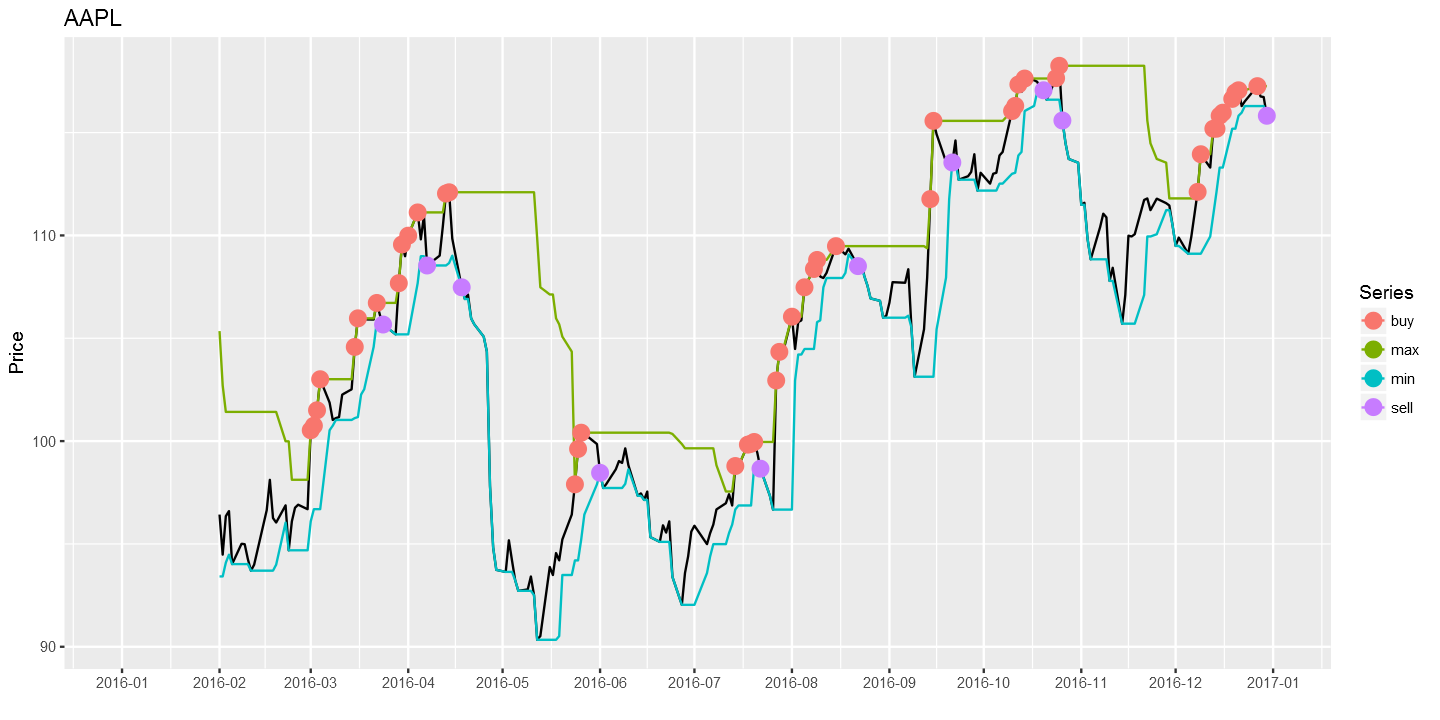

In [126]:
bsdata <- merge(buydata[, 1], selldata[, 1])
names(bsdata) <- c("buy", "sell")
drawPoint(ldata, bsdata, title, sDate, eDate, '1 month')

In [127]:
# Merge the trading signals
signal <- function(buy, sell){
    selldf <- data.frame(sell, op=as.character(rep("S", nrow(sell))))
    buydf <- data.frame(buy, op=as.character(rep("B", nrow(buy))))
    sdata <- rbind(buydf, selldf)
    sdata[order(as.Date(row.names(sdata))), ]
}

sdata <- signal(buydata, selldata)
sdata

,AAPL.Close,min,max,op
2016-03-01,100.53,96.10,100.53,B
2016-03-02,100.75,96.69,100.75,B
2016-03-03,101.50,96.69,101.50,B
2016-03-04,103.01,96.69,103.01,B
2016-03-15,104.58,101.12,104.58,B
2016-03-16,105.97,101.17,105.97,B
2016-03-22,106.72,105.80,106.72,B
2016-03-24,105.67,105.67,106.72,S
2016-03-29,107.68,105.19,107.68,B
2016-03-30,109.56,105.19,109.56,B


## Simulate the trading

In [128]:
trade <- function(sdata, capital=100000, fixMoney=10000){ # signal, total capital, fixed investment
    amount <- 0
    cash <- capital
    
    ticks <- data.frame()
    for(i in 1:nrow(sdata)){
        row <- sdata[i, ]
        if(row$op == 'B'){
            if(cash < fixMoney){
                print(paste(row.names(row), "No enough cash"))
                next
            }
            amount0 <- floor(fixMoney / row[, 1])   # Current trading volume
            amount <- amount + amount0
            cash <- cash - amount0 * row[, 1]
        }
        
        if(row$op == 'S'){
            cash <- cash + amount * row[, 1]
            amount <- 0
        }
        
        row$cash <- round(cash, 2)
        row$amount <- amount
        row$asset <- round(cash + amount * row[, 1], 2)
        ticks <- rbind(ticks, row)
    }
    
    ticks$diff <- c(0, round(diff(ticks$asset), 2))
    
    rise <- ticks[intersect(which(ticks$diff > 0), which(ticks$op == 'S')), ]  # win strategy
    fall <- ticks[intersect(which(ticks$diff < 0), which(ticks$op == 'S')), ]  # lose strategy
    
    return(list(ticks=ticks,
                rise=rise,
                fall=fall))
}

result <- trade(sdata, 100000, 10000)
result

,AAPL.Close,min,max,op,cash,amount,asset,diff
2016-03-01,100.53,96.10,100.53,B,90047.53,99,100000.00,0.00
2016-03-02,100.75,96.69,100.75,B,80073.28,198,100021.78,21.78
2016-03-03,101.50,96.69,101.50,B,70126.28,296,100170.28,148.50
2016-03-04,103.01,96.69,103.01,B,60134.31,393,100617.24,446.96
2016-03-15,104.58,101.12,104.58,B,50199.21,488,101234.25,617.01
2016-03-16,105.97,101.17,105.97,B,40238.03,582,101912.57,678.32
2016-03-22,106.72,105.80,106.72,B,30313.07,675,102349.07,436.50
2016-03-24,105.67,105.67,106.72,S,101640.32,0,101640.32,-708.75
2016-03-29,107.68,105.19,107.68,B,91733.76,92,101640.32,0.00
2016-03-30,109.56,105.19,109.56,B,81763.80,183,101813.28,172.96
